# About
This notebook takes in data from StringDB and constructs a SHEPHARD file that maps uniprot ID to the set of physical interactors identified from UniProt ID.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list,fcluster
import matplotlib.patches as mpatches

import itertools
import metapredict as meta


In [13]:
import protfasta

PRINT_WARNINGS = False

In [3]:
yp = protfasta.read_fasta('../../data/UP000002311_559292_YEAST_v4_uniprot_id.fasta')

## Parse through alias names
The file `4932.protein.aliases.v12.0.txt` has the format `#string_protein_id      alias   source`, where the first column is the string_protein_id, and the second column an alias from some other source. This first loop essentially parses the file so we have a way to

In [16]:
with open('4932.protein.aliases.v12.0.txt','r') as fh:
    content = fh.readlines()


name2ac = {}
name2ensemble = {}


all_names = []
for line in content[1:]:
    sline = line.strip().split('\t')   

    # add the stringID to the list of all names
    all_names.append(sline[0])

    # if the alias source is the UniProt_AC (UniPro accession)
    if sline[2] == 'UniProt_AC':

        # have we seen this name before, if not, initialize!
        if sline[0] not in name2ac:
            name2ac[sline[0]] = []            

        # associated this accession with the string ID
        name2ac[sline[0]].append(sline[1])

    # if the alias is Ensembl_UniProt do the same thing
    if sline[2] == 'Ensembl_UniProt':
        if sline[0] not in name2ensemble:
            name2ensemble[sline[0]] = []            
        
        name2ensemble[sline[0]].append(sline[1])

##
## At this stage we have two dictionaries: name2ac and name2ensemble, both of these map a stringDB ID to a list of UniProt IDs
## 

# remove redundant names 
all_names = list(set(all_names))

# define our final mapping dictionary
final_mapping = {}

# cycle over each string DB
for k in all_names:

    # initialize
    done = False
    found = False

    # try and read this accession 
    try:

        # remove redundant things; if this works
        # we set found = True, else if this name is
        # not found in the name2ac this will trigger
        # an exception which is FINE.
        collapsed = list(set(name2ac[k]))
        found = True
    except KeyError:
        if PRINT_WARNINGS:
            print(f'Could not find {k} in AC')              

    # if the name was in the name2ac
    if found:        

        # if we had 2 or more uniprot IDs
        if len(collapsed) >1:  

            # for each uniprot ID
            for u in collapsed:

                # if that ID is found in our yeast proteome dictionary,
                # we take it as the ID we care about and stop. This means 
                if u in yp:
                    done = True
                    final_mapping[k] = u
                    break
                    
        # if we only had one uniprot ID we
        # take that as the de facto uniprot ID to use
        else:
            if collapsed[0] in yp:
                done = True        
                final_mapping[k] = collapsed[0]

        # if we mapped the name to a uniprot ID than 
        # we bail
        if done:
            continue

    ##
    # we now repeat the same protocol as done anove for the name2ensemble
    # dictionary.
    try:
        collapsed = list(set(name2ensemble[k]))
        found = True
    except KeyError:
        if PRINT_WARNINGS:
            print(f'Could not find {k} in name2ensemble')              
        continue

    if len(collapsed) >2:
        for u in collapsed:
            if u in yp:
                done = True
                final_mapping[k] = u
                break
                
       
    else:
        if collapsed[0] in yp:
            done = True        
            final_mapping[k] = collapsed[0]

    if done is False:
        pass


        


### Status
We're now left with a dictionary called final mapping that relates StringDB IDs to UniProt IDs

In [17]:
# read in the interactome data, which is of the format
# protein1 protein2 combined_score, where proetin1 and protein2 use StringDB IDs
with open('4932.protein.physical.links.v12.0.txt','r') as fh:
    content = fh.readlines()



In [18]:
# PARAMETER - set between 0 and 999 for less/more confident. By default we do not filter this
evidence_filter = 0


id2id = {}
missed = 0
hits = 0
filtered_by_evidence = 0
kept_after_filtering = 0

if evidence_filter < 0 or evidence_filter >= 1000:
    raise Exception('Evidence filter must be between 0 and 1000')
    
for line in content[1:]:
    sline = line.strip().split()

    # convert the two stringDB IDs to UniProt
    # IDs if possible (id1 and id2 are UniProt IDs)
    try:
        id1 = final_mapping[sline[0]]
        id2 = final_mapping[sline[1]]
        hits = hits + 1
    except KeyError as e:
        missed = missed + 1        
        continue

    
    ev = int(sline[2])
    if ev < evidence_filter:
        filtered_by_evidence = filtered_by_evidence +1
        continue

    kept_after_filtering = kept_after_filtering + 1
    
    # if id1 or id2 not yet seen initialize
    # the mapping list for id1 and id2 in the id2id dictionary
    if id1 not in id2id:
        id2id[id1] = []
    if id2 not in id2id:
        id2id[id2] = []

    # update the mapping dictionary
    id2id[id1].append([id2, ev])
    id2id[id2].append([id1, ev])
        

print(f"Unable to map {round(100*missed/(hits+missed),2)} % of the interaction pairs")
print(f"Filtered out {round(100*filtered_by_evidence/(filtered_by_evidence+kept_after_filtering),2)} % of the interaction pairs")



Unable to map 1.14 % of the interaction pairs
Filtered out 0.0 % of the interaction pairs


In [19]:
# finally remove any redundant pairs
id2id_unique = {}
for k in id2id:
    tmp = list(set([i[0] for i in id2id[k]]))
    tmp.sort()
    id2id_unique[k] = tmp

# and count how many interactors each ID has
id2count = {}
for k in id2id_unique:
    id2count[k] = len(id2id_unique[k])


id2count = {k: v for k, v in sorted(id2count.items(), key=lambda item: item[1],reverse=True)}

In [20]:
c=0
for k in id2count:
    if id2count[k]> 100:
        c=c+1

In [21]:
c/len(id2count)

0.15495685860186653

Sanity check


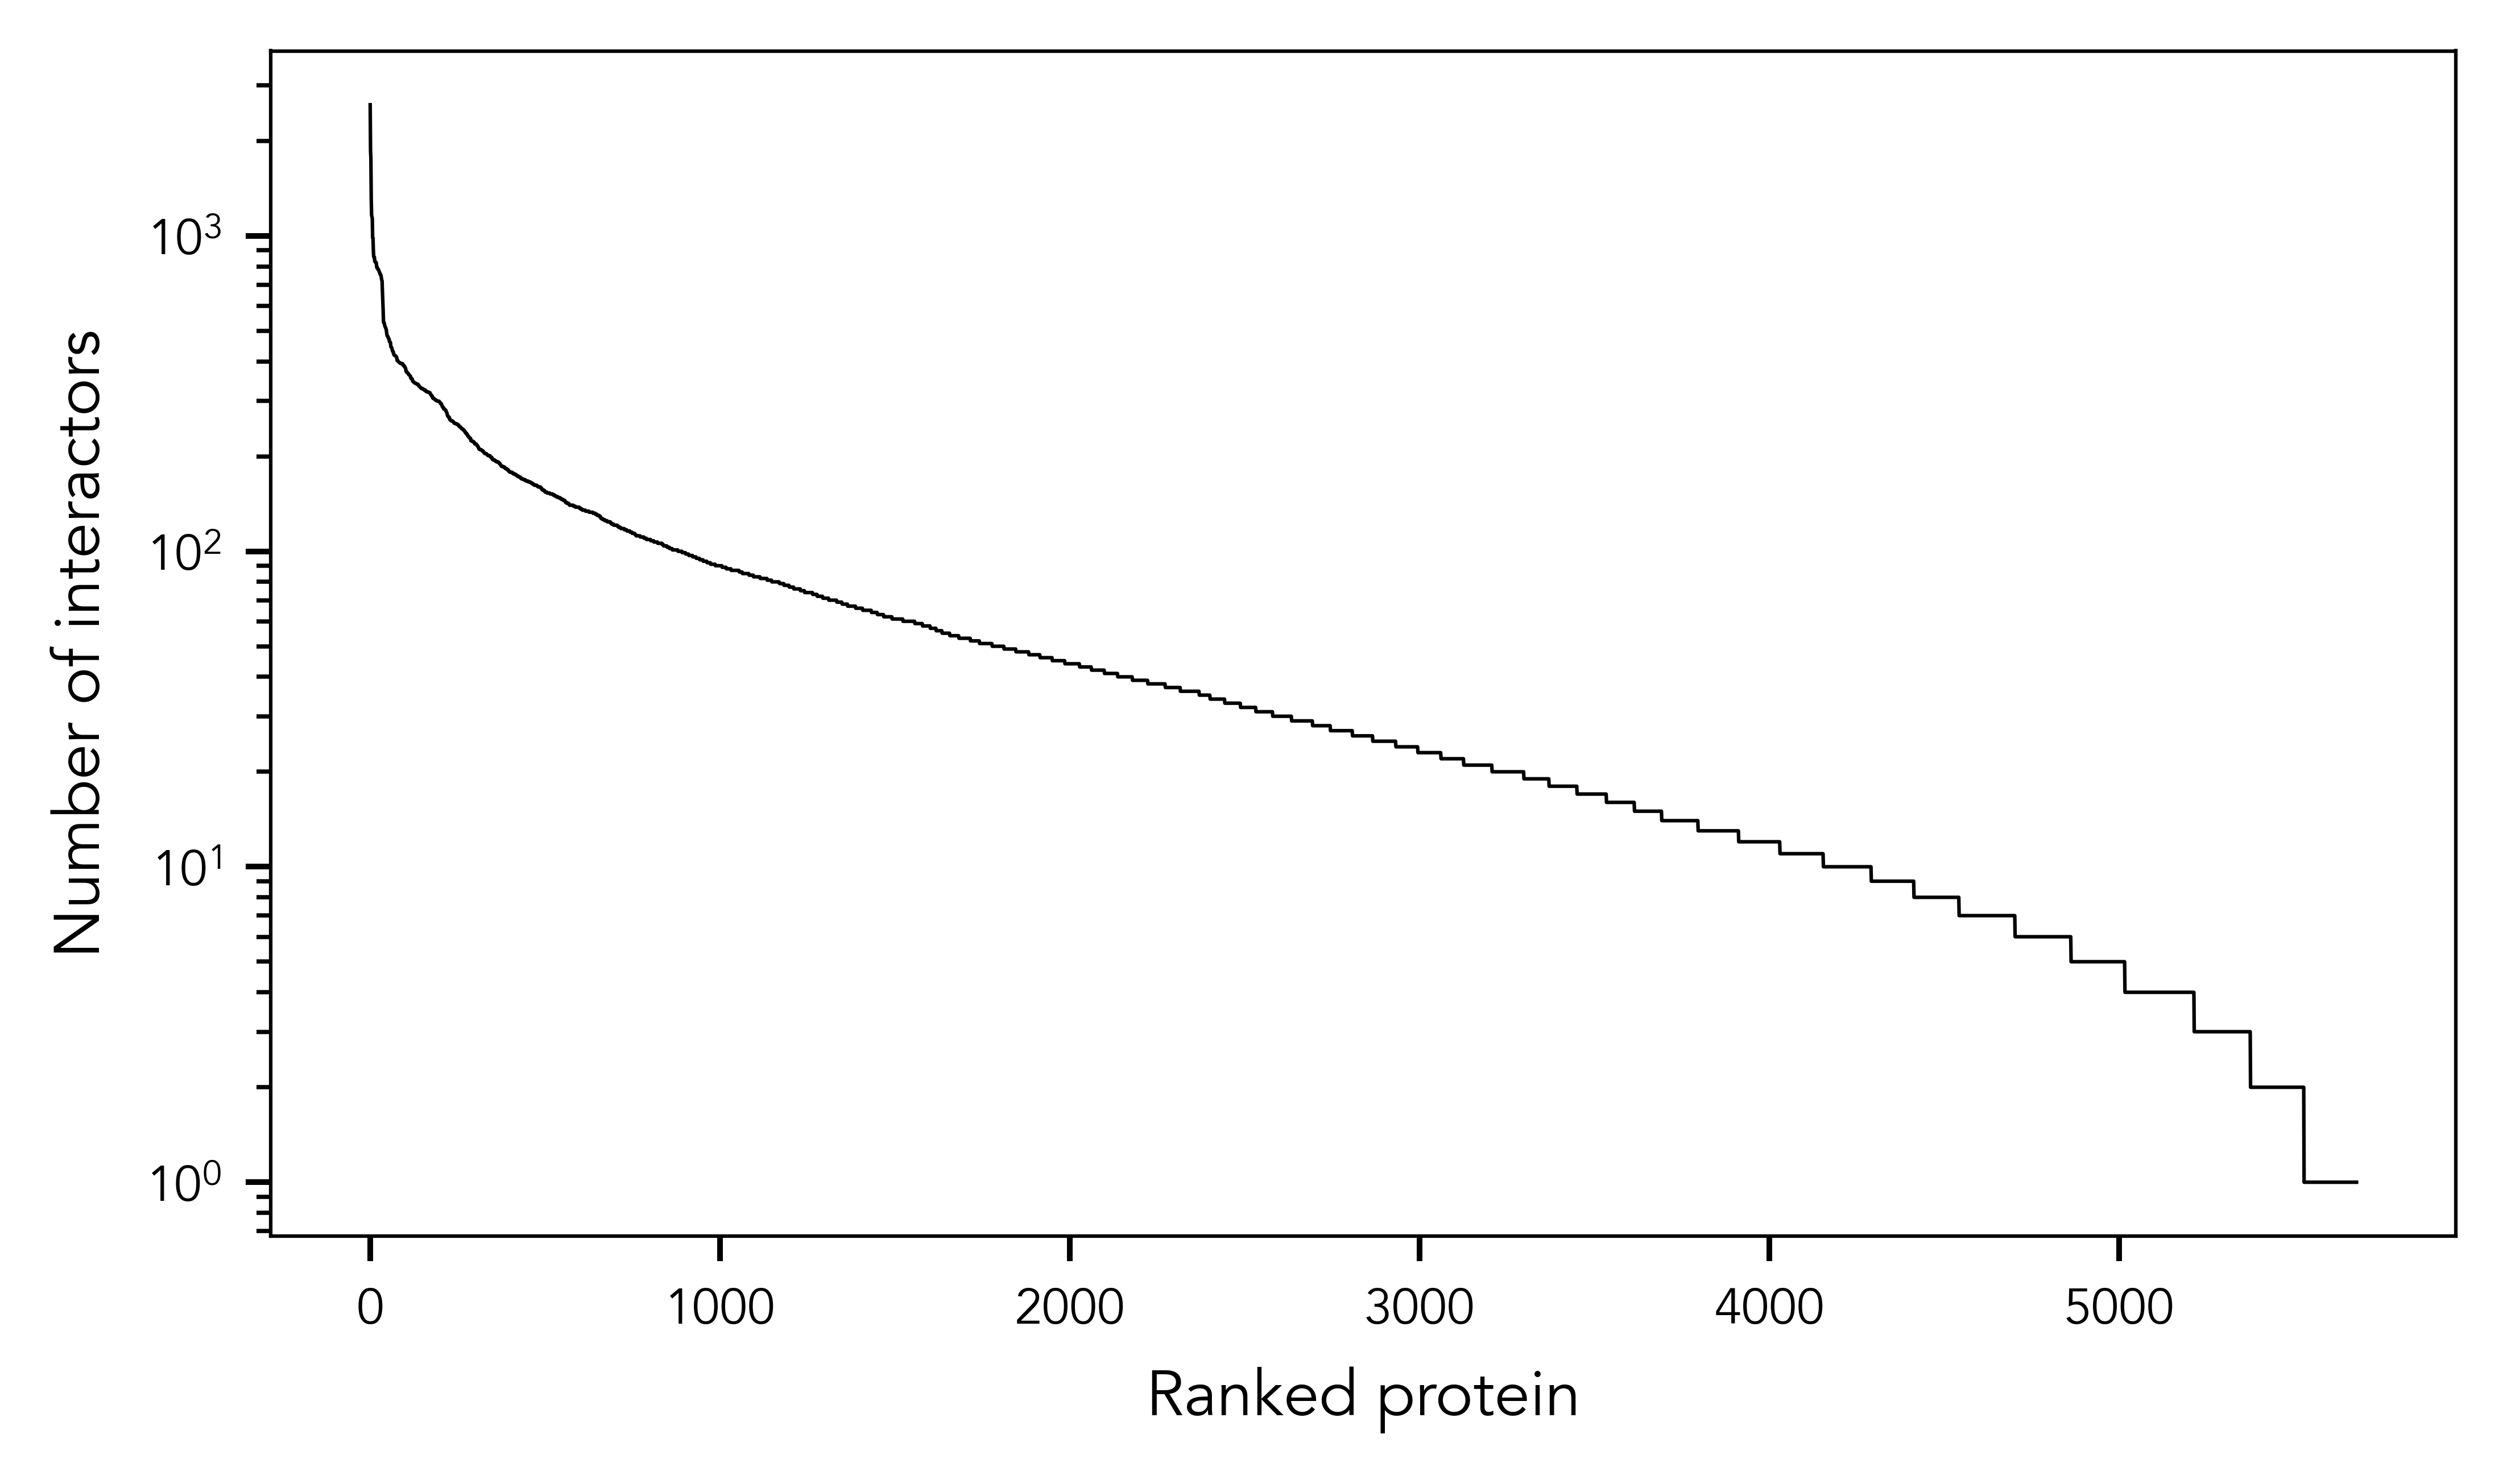

In [29]:
print('Sanity check')
figure(None,(5,3), dpi=450)
counts = list(id2count.values())
counts.sort(reverse=True)
plt.plot(counts, color='k',lw=0.5)
plt.yscale('log')
plt.xlabel('Ranked protein', fontsize=9)
plt.ylabel('Number of interactors', fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig('interactor_summary.pdf')


In [11]:
# write SHEPHARD file out
with open('shprd_interactome.tsv','w') as fh:
    for k in id2id_unique:

        partners = ", ".join(id2id_unique[k])
        
        fh.write(f'{k}\tinteract_count:{id2count[k]}\tpartners:{partners}\n')

In [12]:
# write simpler CSV file that maps uniprot ID to number of interactors

with open('uniprot2count.csv','w') as fh:
    for k in id2count:
        fh.write(f'{k}, {id2count[k]}\n')